# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import scipy

# Constants & Parameters

Note, all distances are in $cm$, and lamp power is in $W$ (this decision was made since experiental results for virus deactivation have measured irradiation in $mJ/cm^2$

For the calculations further down, the wattage is converted to $mW$

In [2]:
box_width = 60
box_depth = 30

In [3]:
lamp_height = 35      # The height of each lamp, used for W/mm intensity
lamp_wattage = 48     # The Wattage of each lamp
uv_efficiency = 0.27  # The % of lamp_intensity which results in UVC light
lamp_radius = 2       # Only used for the graphics

Derive the effective wattage (in $mW$ per $cm$ of lamp)

In [4]:
effective_mwatts_per_cm = lamp_wattage * 1000 * uv_efficiency / lamp_height
print(f'Effective Wattage per length of lamp: {effective_mwatts_per_cm:.2f}mW/cm')

Effective Wattage per length of lamp: 370.29mW/cm


# Model

At a distance from a light source, irradiance is given by the power per unit area: $P/A$ where $P$ is the power of the source ($W$) and $A$ is the area of the surface at a given distance from the source.

Since the lamps are vertically aligned, we can approximate the area being irradiated as a cylinder around each unit segment of the lamp (with long lamps this should be reasonable - some light from the middle of the lamp will irradiate particles near the top of the lamp, but the top of the lamp will symmetrically be irradiating particles in the middle). This breaks down at the ends, where some light will be lost, but I'll ignore this effect for now, it shouldnt cause order-of-magnitude differences.

With the cylindrical assumption, irradiance at a distance $x$ from a lamp will be equal to $\frac{\sigma}{2 \pi x h}$

Where $\sigma$ is the power per unit length (`effective_mwatts_per_cm` in this notebook) and $h$ is the unit length (`1cm` in this notebook)

**ASSUMPTIONS:** 
* A cylindrical approximation to UV light radiation is not too far off the mark (within a factor of 2 or so), so is still a useful model.
* This model assumes 0 reflection of the UV light. With reflective material around the edges (not top and bottom) of the chamber, we could reasonably expect at least half of the total UV generated to be reflected back into the chamber (reflective materials are available with >95% reflectivity). This should be easily enough to cancel out modelling deficiencies with the cylindrical assumption.
* All these calculations assume no significant decrease in UV intensity as it passess through the air. I think this should be a reasonable assumption given the error margins we're dealing with, but it would be good to get some validation that this is reasonable.
* We ignore the effect of one lamp shielding the UV light from another, as a second order effect. Since intensity decreases as an inverse square, the closest lamp to any one point should dominate anyway.

## Grid Definition

The parameters `x_grid` and `y_grid` represent the `x` and `y` coordinates of 1mm square points within the box

In [5]:
step_size = 0.1

x_grid, y_grid = np.meshgrid(
    np.arange(0, box_width + step_size, step_size), 
    np.arange(0, box_depth + step_size, step_size)
)

print('x_grid\n')
print(x_grid[:2], '\n...')
print('\ny_grid\n')
print(y_grid[:2], '\n...')

x_grid

[[ 0.   0.1  0.2 ... 59.8 59.9 60. ]
 [ 0.   0.1  0.2 ... 59.8 59.9 60. ]] 
...

y_grid

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]] 
...


## Calculations

In [6]:
def irradiance_from_lamp(power_per_unit, x, y, lamp_x, lamp_y, lamp_radius=0):
    """The irradiance at points (x, y) from a lamp at (lamp_x, lamp_y)"""
    sq_dist = (x - lamp_x) ** 2 + (y - lamp_y) ** 2
    distance = sq_dist ** 0.5
    # Avoid division by 0 errors, and remove lamp points
    distance[distance <= lamp_radius] = np.nan
    # Do not need to multiple denominator by unit height as it is 1 (cm)
    irradiance = power_per_unit / (2 * np.pi * distance)
    return irradiance


def total_irradiance_from_lamps(power_per_unit, x, y, lamps_x, lamps_y, lamp_radius=0):
    """The total irradiance at points (x, y) from lamp at (x_lamps, y_lamps)"""
    return sum(
        irradiance_from_lamp(power_per_unit, x, y, lx, ly, lamp_radius)
        for lx, ly in zip(lamps_x, lamps_y)
    )

### Calculate irradiance based on the constants provided

In [7]:
def model_irradiance(lamps_x, lamps_y):
    """Return a grid of irradiances based on x_grid and y_grid and lamp positions"""
    return total_irradiance_from_lamps(
        effective_mwatts_per_cm, x_grid, y_grid,
        lamps_x, lamps_y, lamp_radius
    )

### Functions for displaying the output

In [8]:
def plot_irradiance(lamps_x, lamps_y, max_percentile=90, width=12):
    """Plot the irradiance (max_percentile determines the heat scale)"""
    # Plot a figure that is to scale
    plt.figure(figsize=(width, width*box_depth/box_width))
    
    irradiance = model_irradiance(lamps_x, lamps_y)
    scale_max = np.nanpercentile(irradiance, max_percentile)
    seaborn.heatmap(
        irradiance, 
        vmin=np.nanmin(irradiance), 
        vmax=scale_max, 
        xticklabels=[],
        yticklabels=[],
    )
    plt.title(
        "UVC irradiance (mW/cm2)\n" \
        f"(max clipped to {max_percentile}th percentile value)"
    )
    

def display_stats(lamps_x, lamps_y):
    irradiance = model_irradiance(lamps_x, lamps_y)
    min_irr = np.nanmin(irradiance)
    mean_irr = np.nanmean(irradiance)
    median_irr = np.nanmedian(irradiance)
    print("Lamp locations:")
    print(", ".join(f"({x:.1f}cm, {y:.1f}cm)" for x, y in zip(lamps_x, lamps_y)))
    print()
    print(f"Minimum irradiance: {min_irr:.2f}mW/cm2")
    print(f"Mean irradiance: {mean_irr:.2f}mW/cm2")
    print(f"Median irradiance: {median_irr:.2f}mW/cm2")
    return {
        'minimum': min_irr, 
        'mean': mean_irr, 
        'median': median_irr,
    }
    
    
def evaluate(lamps_x, lamps_y, max_percentile=90, width=12):
    irradiance = model_irradiance(lamps_x, lamps_y)
    plot_irradiance(lamps_x, lamps_y, max_percentile, width)
    return display_stats(lamps_x, lamps_y)

# Example Lamp Layout

With the originally provided lamp layout suggestion from Michele, the calculated irradiances are shown below. This illustrates the ways in which results can be calculated for any layout suggestions.

<img src="michele_lamp_model.png" alt="Drawing" style="width: 400px;"/>

Lamp locations:
(15.0cm, 10.0cm), (30.0cm, 20.0cm), (45.0cm, 10.0cm)

Minimum irradiance: 5.42mW/cm2
Mean irradiance: 12.29mW/cm2
Median irradiance: 11.22mW/cm2


{'minimum': 5.417674782607354,
 'mean': 12.289709170302354,
 'median': 11.217752545534726}

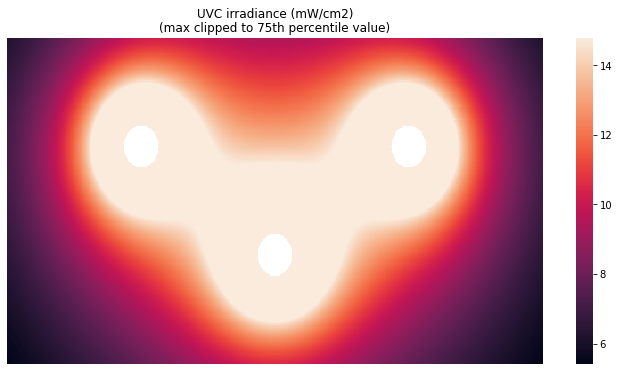

In [9]:
lamps_x = [15, 30, 45]
lamps_y = [10, 20, 10]

evaluate(lamps_x, lamps_y, max_percentile=75)

# Optimise Lamp Positions

To optimise lamp positions, I've targetted maximising the minimum irradiation. One of the biggest concerns we have is that some air could be passed through at high speed, and spread around the room taking virus with it. Having a high mean irradiation isn't good enough if there are some airflows which don't see enough UV to kill the virus.

The optimisation at the moment starts by minimising mean inverse irradiance (this gives a smooth optimisation function, and allows a sensible layout to be discovered more easily). Once this layout is determined, a second optimisation pass is carried out, using the minimum irradiance as the objective function.

In [10]:
def generate_bounds(lamps_x, lamps_y):
    """The parameter boundaries (lamp must be inside the box)"""
    return (
        ((lamp_radius, box_width-lamp_radius),) * len(lamps_x) + 
        ((lamp_radius, box_depth-lamp_radius),) * len(lamps_y)
    )


def get_objective_function(cost_fun):
    """Generates an objective function using the cost_fun specified"""
    
    def objective_function(lamps_xy):
        """lamps_xy is a 1D array where the first half is x-coordinates, and the second half is y-coordinates
        This is necessary as the optimiser requires 1D arrays to work with.
        """
        # This has to take one array, so we can split this up here
        lamps_x, lamps_y = np.split(lamps_xy, 2)
        irradiance = model_irradiance(lamps_x, lamps_y)
        return cost_fun(irradiance)

    return objective_function


def optimise_positions(lamps_x, lamps_y, cost_fun):
    """Optimise the positions of the lamps, given a cost_function
    
    This cost function should expect a 2D array of irradiances, and return a scalar. It is used to generate
    the objective function for one pass of the optimization.
    """
    lamps_xy = np.concatenate([lamps_x, lamps_y])
    result = scipy.optimize.minimize(
        get_objective_function(cost_fun), 
        lamps_xy,
        bounds=generate_bounds(lamps_x, lamps_y),
    )
    return np.split(result['x'], 2)

In [11]:
def generate_starting_positions(n_lamps):
    x = np.random.random(n_lamps) * (box_width - 2 * lamp_radius) + lamp_radius
    y = np.random.random(n_lamps) * (box_depth - 2 * lamp_radius) + lamp_radius
    return x, y


def perform_optimisation(lamps_x_orig=None, lamps_y_orig=None, n_lamps=1):
    """Performs a multi-pass optimisation, printing out intermediate and final results"""
    if lamps_x_orig is None or lamps_y_orig is None:
        lamps_x_orig, lamps_y_orig = generate_starting_positions(n_lamps)
        
    print("Initial Layout:")
    evaluate(lamps_x_orig, lamps_y_orig, width=6);
    plt.show()
    print("Optimized first pass (using mean inverse irradiance):")
    lamps_x_1, lamps_y_1 = optimise_positions(lamps_x_orig, lamps_y_orig, cost_fun=lambda irr: np.nanmean(1/irr))
    print("Optimized second pass (using minimum irradiance):")
    lamps_x, lamps_y = optimise_positions(lamps_x_1, lamps_y_1, cost_fun=lambda irr: np.nanmean(1/irr))
    lamps_x, lamps_y = optimise_positions(lamps_x, lamps_y, cost_fun=lambda irr: -np.nanmin(np.log(irr)))
    results = evaluate(lamps_x, lamps_y)
    # Print the irradiance with a condensed scale to better illustrate low intensity areas.
    plot_irradiance(lamps_x, lamps_y, 50)
    return results

# Optimised results for different lamp numbers

The plane positions of each lamp (assumed vertical within the box)

In [12]:
results = {}

## One Lamp (Test case)

If the optimiser is working well, this should put the lamp exactly in the middle.

Initial Layout:
Lamp locations:
(27.1cm, 18.4cm)

Minimum irradiance: 1.56mW/cm2
Mean irradiance: 4.28mW/cm2
Median irradiance: 3.25mW/cm2


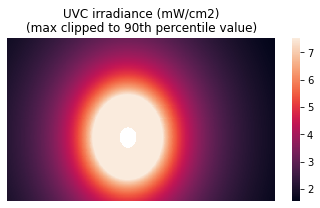

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(30.0cm, 15.0cm)

Minimum irradiance: 1.76mW/cm2
Mean irradiance: 4.34mW/cm2
Median irradiance: 3.35mW/cm2


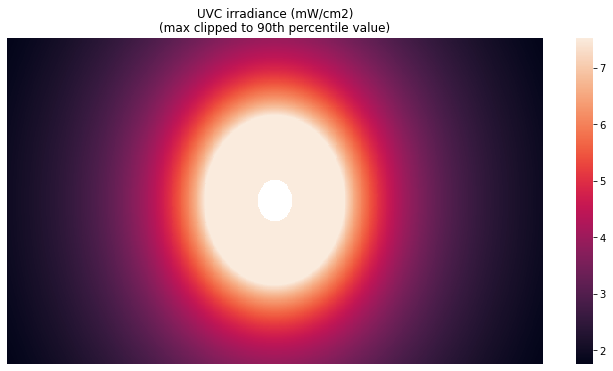

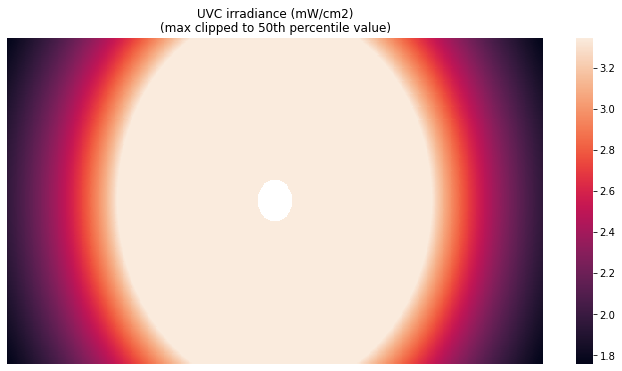

In [13]:
results['1'] = perform_optimisation(n_lamps=1)

## Two Lamps

Initial Layout:
Lamp locations:
(21.1cm, 9.6cm), (41.1cm, 9.7cm)

Minimum irradiance: 3.29mW/cm2
Mean irradiance: 8.26mW/cm2
Median irradiance: 6.82mW/cm2


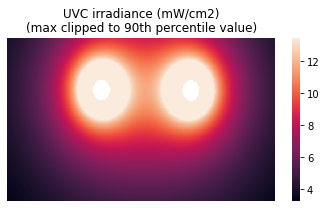

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(8.6cm, 15.0cm), (51.4cm, 15.0cm)

Minimum irradiance: 4.51mW/cm2
Mean irradiance: 7.57mW/cm2
Median irradiance: 6.19mW/cm2


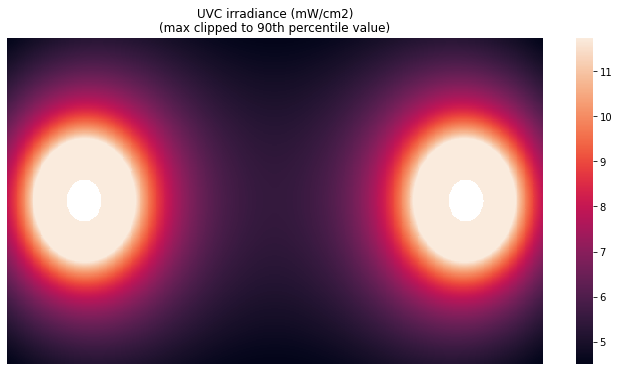

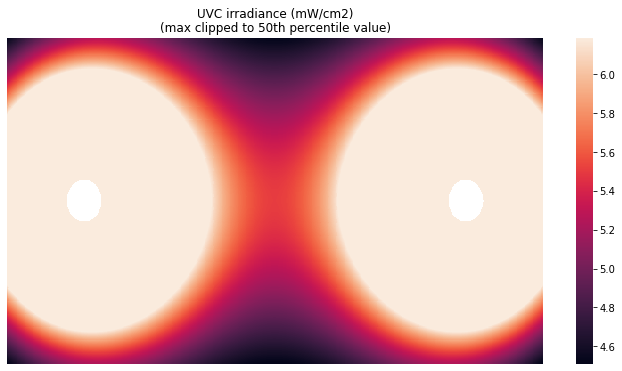

In [14]:
results['2'] = perform_optimisation(n_lamps=2)

## Three Lamps

### Using random start position

Initial Layout:
Lamp locations:
(2.9cm, 27.1cm), (18.8cm, 15.2cm), (4.1cm, 13.4cm)

Minimum irradiance: 3.30mW/cm2
Mean irradiance: 10.33mW/cm2
Median irradiance: 7.97mW/cm2


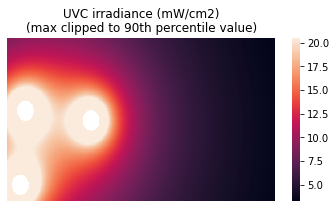

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(29.8cm, 15.7cm), (58.0cm, 14.9cm), (2.0cm, 14.8cm)

Minimum irradiance: 6.62mW/cm2
Mean irradiance: 10.60mW/cm2
Median irradiance: 9.51mW/cm2


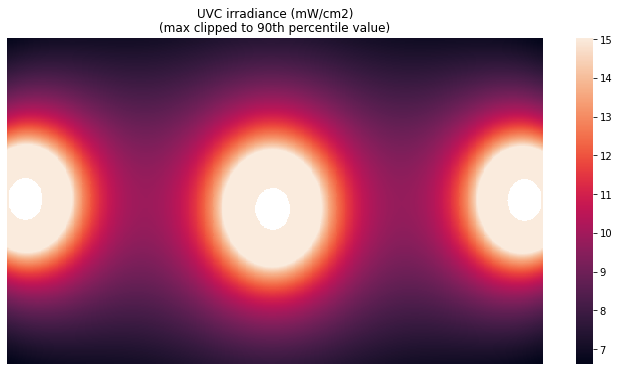

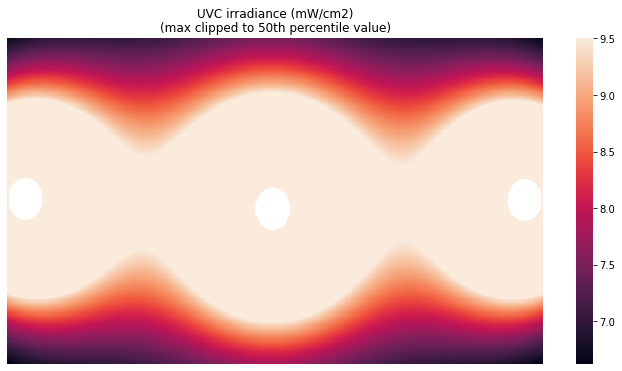

In [29]:
results['3'] = perform_optimisation(n_lamps=3)

### Starting from edges


Initial Layout:
Lamp locations:
(0.0cm, 0.0cm), (30.0cm, 30.0cm), (60.0cm, 0.0cm)

Minimum irradiance: 4.81mW/cm2
Mean irradiance: 7.82mW/cm2
Median irradiance: 6.90mW/cm2


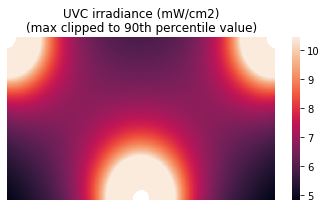

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(2.6cm, 14.7cm), (29.8cm, 18.2cm), (57.8cm, 14.7cm)

Minimum irradiance: 6.62mW/cm2
Mean irradiance: 10.69mW/cm2
Median irradiance: 9.59mW/cm2


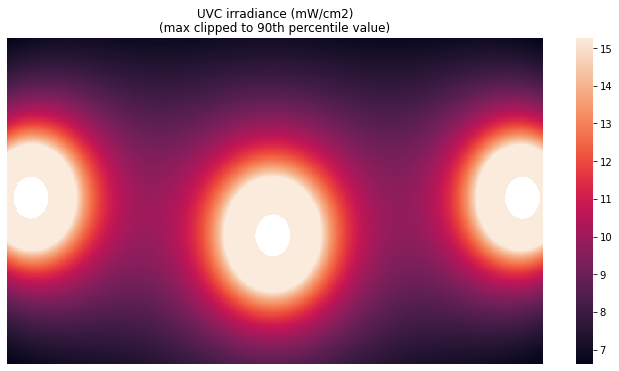

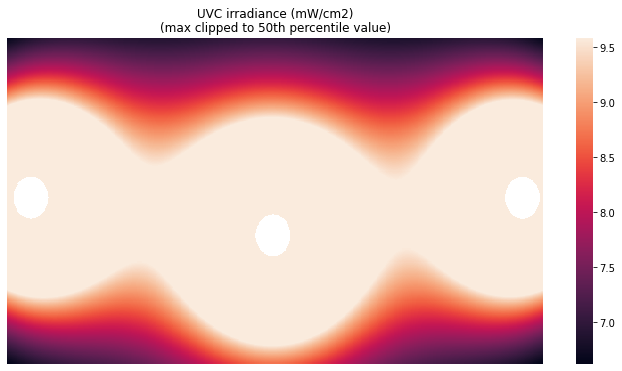

In [16]:
results['3 (alternate layout)'] = perform_optimisation([0, box_width/2, box_width], [0, box_depth, 0])

## Four Lamps

### Using random start position

Initial Layout:
Lamp locations:
(3.8cm, 14.2cm), (19.6cm, 2.7cm), (44.4cm, 8.0cm), (29.7cm, 17.3cm)

Minimum irradiance: 6.20mW/cm2
Mean irradiance: 15.23mW/cm2
Median irradiance: 14.64mW/cm2


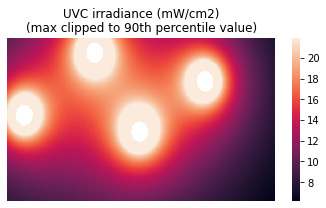

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(2.0cm, 16.4cm), (15.4cm, 11.2cm), (58.0cm, 13.2cm), (47.6cm, 16.9cm)

Minimum irradiance: 8.82mW/cm2
Mean irradiance: 14.30mW/cm2
Median irradiance: 12.36mW/cm2


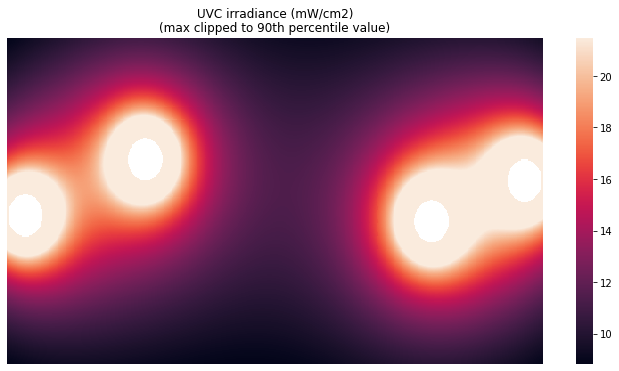

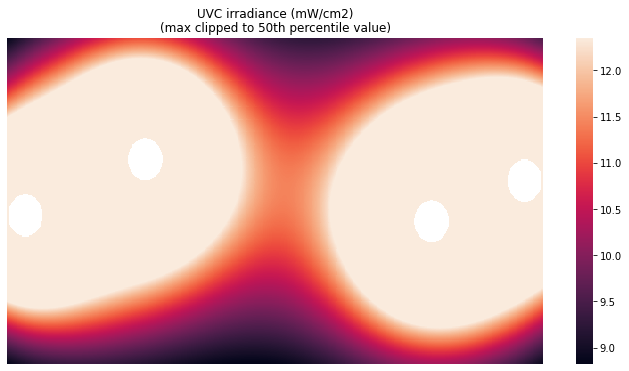

In [49]:
results['4'] = perform_optimisation(n_lamps=4)

### Starting from corners

Initial Layout:
Lamp locations:
(0.0cm, 0.0cm), (0.0cm, 30.0cm), (60.0cm, 0.0cm), (60.0cm, 30.0cm)

Minimum irradiance: 6.71mW/cm2
Mean irradiance: 9.09mW/cm2
Median irradiance: 8.10mW/cm2


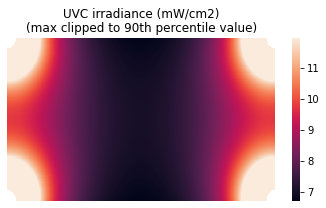

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(10.5cm, 4.2cm), (10.5cm, 25.7cm), (49.6cm, 4.1cm), (49.5cm, 25.8cm)

Minimum irradiance: 9.55mW/cm2
Mean irradiance: 13.88mW/cm2
Median irradiance: 12.51mW/cm2


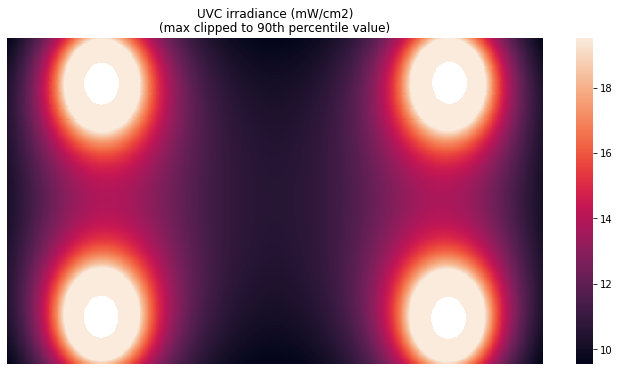

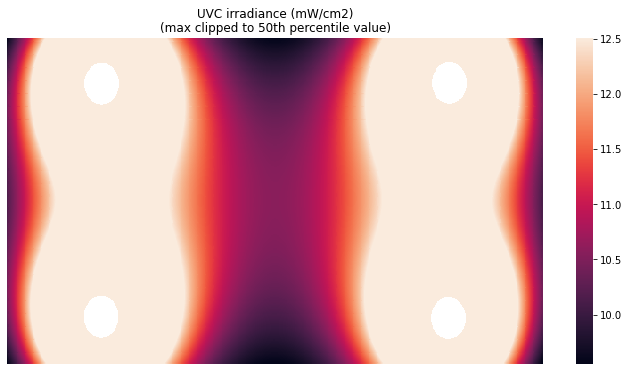

In [32]:
results['4 (alternate layout)'] = perform_optimisation(
    [0, 0, box_width, box_width], 
    [0, box_depth, 0, box_depth]
)

## Five lamps

### Using random start positions

Initial Layout:
Lamp locations:
(56.4cm, 24.1cm), (48.6cm, 20.3cm), (17.4cm, 16.4cm), (33.3cm, 2.5cm), (17.6cm, 27.5cm)

Minimum irradiance: 8.12mW/cm2
Mean irradiance: 18.26mW/cm2
Median irradiance: 17.39mW/cm2


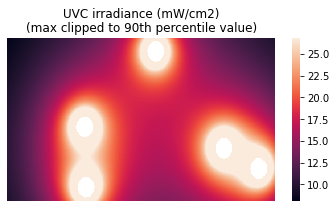

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(52.8cm, 25.1cm), (51.4cm, 3.5cm), (7.6cm, 3.7cm), (31.1cm, 15.6cm), (7.7cm, 25.6cm)

Minimum irradiance: 12.51mW/cm2
Mean irradiance: 17.68mW/cm2
Median irradiance: 16.43mW/cm2


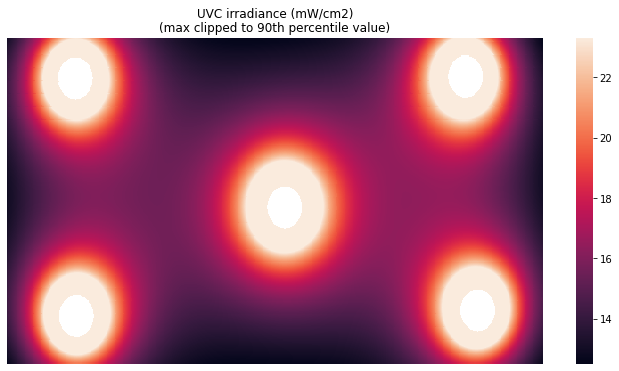

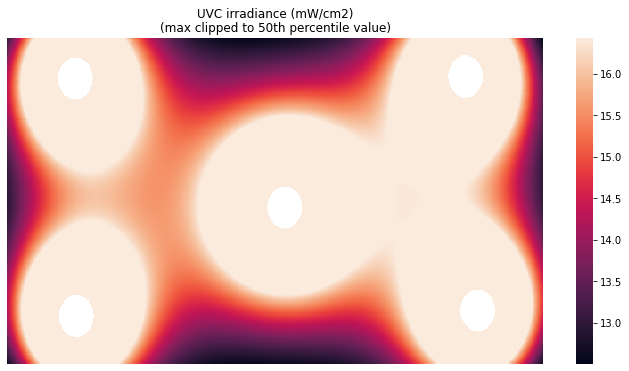

In [37]:
results['5'] = perform_optimisation(n_lamps=5)

### Using symmetric start positions

Initial Layout:
Lamp locations:
(0.0cm, 0.0cm), (0.0cm, 30.0cm), (30.0cm, 15.0cm), (60.0cm, 0.0cm), (60.0cm, 30.0cm)

Minimum irradiance: 10.49mW/cm2
Mean irradiance: 13.46mW/cm2
Median irradiance: 12.18mW/cm2


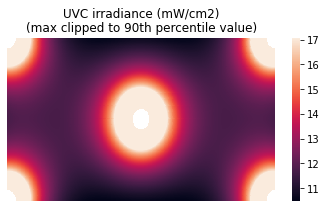

Optimized first pass (using mean inverse irradiance):
Optimized second pass (using minimum irradiance):
Lamp locations:
(8.1cm, 3.8cm), (8.0cm, 26.1cm), (32.2cm, 14.9cm), (51.8cm, 3.9cm), (51.4cm, 26.9cm)

Minimum irradiance: 12.58mW/cm2
Mean irradiance: 17.61mW/cm2
Median irradiance: 16.38mW/cm2


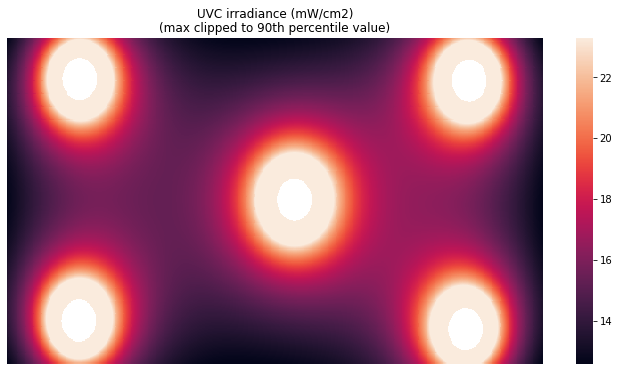

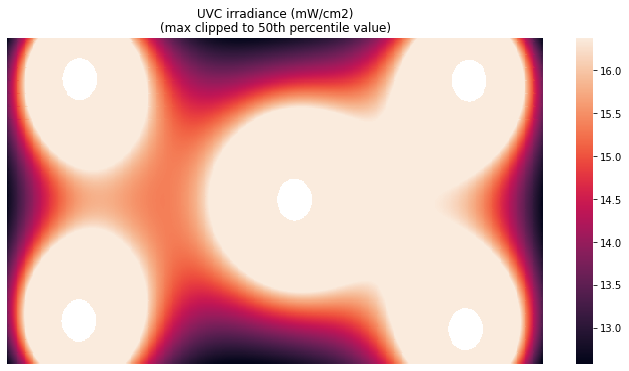

In [34]:
results['5 (alternate layout)'] = perform_optimisation(
    [0, 0, box_width/2, box_width, box_width], 
    [0, box_depth, box_depth/2, 0, box_depth]
)

# Results

In [50]:
results_table = pd.DataFrame(results).T.round(2)
results_table.index.name = "No. of Lamps"
results_table.columns.name = "Irradiance (mW/cm2)"

Irradiance (mW/cm2),minimum,mean,median
No. of Lamps,,,
1,1.76,4.34,3.35
2,4.51,7.57,6.19
3,6.62,10.60,9.51
3 (alternate layout),6.62,10.69,9.59
4,8.82,14.30,12.36
4 (alternate layout),9.55,13.88,12.51
5,12.51,17.68,16.43
5 (alternate layout),12.58,17.61,16.38


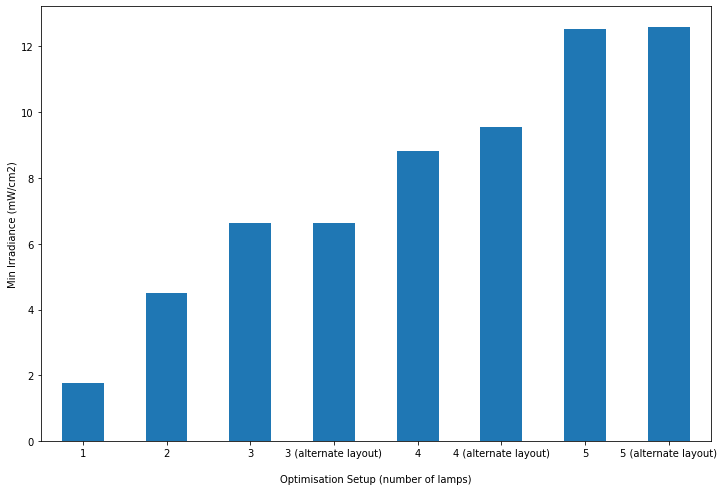

In [51]:
display(results_table)
print()
ax = results_table.plot.bar(y='minimum', figsize=(12, 8), rot=0, legend=None)
ax.set_ylabel("Min " + results_table.columns.name)
ax.set_xlabel("\nOptimisation Setup (number of lamps)");

## Total UV dose received by aerosols

The total viral death rate is proportional to the total UV energy absorbed by each volume unit of air. This is the product of the irradiance of the UV lamps within the chamber ($E_\theta$, measured in $mW/cm^2$), and the amount of time air spends in the 'kill zone' ($t$) - this zone is assumed to be the area level with the lamps, giving the kill zone a height of `lamp_height` ($l$ in the equation below), defined at the top of this notebook. For example, if airflow were $1m/s$, the kill zone were $50cm$ long, and the minimum irradiance within the chamber were $2mW/cm^2$, then:
* The total time spend in the kill zone would be $0.5s$
* The total energy dose recived would thereword be $0.5s \times 2mW/cm^2 = 1mJ/cm^2$

In general, the dose received is equal to: $E_\theta t$ or $\frac{E_\theta l}{s}$, where $s$ is air speed

In [52]:
air_speeds_m_per_s = np.array([0.5, 1, 2, 3, 4])

In [53]:
air_speeds_cm_per_s = air_speeds_m_per_s * 100

minimum_irradiations = results_table['minimum'].values.reshape((-1, 1))

minimum_uv_dose = pd.DataFrame(
    minimum_irradiations * lamp_height / air_speeds_cm_per_s,
    index=results_table.index,
    columns=map(str, air_speeds_m_per_s),
)
minimum_uv_dose.columns.name = "Air speed (m/s)"
minimum_uv_dose = minimum_uv_dose.round(2)

The data in the table and chart below show the ***minimum*** total UV dose received by aerosol particles going through the box for various air speeds, calculated using the equation above.


Minimum UV dose for aerosols passing through the box(mJ/cm2)


Air speed (m/s),0.5,1.0,2.0,3.0,4.0
No. of Lamps,,,,,
1,1.23,0.62,0.31,0.21,0.15
2,3.16,1.58,0.79,0.53,0.39
3,4.63,2.32,1.16,0.77,0.58
3 (alternate layout),4.63,2.32,1.16,0.77,0.58
4,6.17,3.09,1.54,1.03,0.77
4 (alternate layout),6.68,3.34,1.67,1.11,0.84
5,8.76,4.38,2.19,1.46,1.09
5 (alternate layout),8.81,4.40,2.20,1.47,1.10


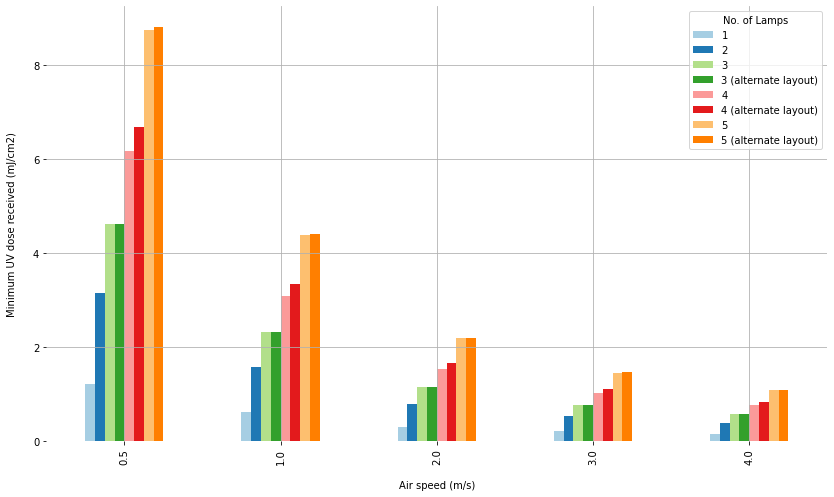

In [54]:
print("\nMinimum UV dose for aerosols passing through the box(mJ/cm2)")
display(minimum_uv_dose)
print()
minimum_uv_dose.T.plot.bar(figsize=(14, 8), color=seaborn.color_palette("Paired"))
plt.ylabel("Minimum UV dose received (mJ/cm2)\n");
plt.xlabel("\nAir speed (m/s)")
plt.grid()
plt.box(False)

## Effect of UV load

To estimate the viral deactivation percentage from this, we can use estimates from other studies. For example, [this study](https://www.nature.com/articles/s41598-018-21058-w) investigated a link between far-UV light dosage and the % of virus aerosols deactivated. It found a decrease of 2 orders of magnitude in viral load at a $2mJ/cm^2$ UV dose.

<img src="viral_deactivation_chart.png" alt="Drawing" style="width: 400px;"/>

This study was for the H1N1 flu virus, so reslts would likely be different for Sars-Cov2, but we hope that the results would be within an order of magnitude.

**TODO:** Investigate this further - more references? I have a feeling there was another study suggesting 3 orders of magnitude decrease for $2mJ/cm^2$